## Classification using Torchtext and Pytorch

- bindirectional LSTM on some news
- some labeled data on news...

- Torchtext to help us numericalize adn load some data
- Torchtext is backed by Pytorch.... so naturally troch text is quite good
- Torchtext is not meant to replace spacy... spacy is still litke better in general
    
- Pytorch to help us make some neural network

In [1]:
# !pip install torchdata

In [2]:
# !pip install torchtext

In [3]:
import torch
import torchdata
import torchtext
from torch import nn
import time

#1. puffer - it's outdated
#2. spend some money - 300 baht get collab pro
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [4]:
torch.__version__

'1.13.1+cu117'

In [5]:
torchdata.__version__

'0.5.1'

In [6]:
torchtext.__version__

'0.14.1'

## 1. Load the dataset

Make our life easy by using some ready-to-be-used dataset by torchtext

- In your assignment, i will ask you to use penn treebank

In [7]:
#if you are using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [8]:
train #a new object by torchdata ......... streaming data (yield)

ShardingFilterIterDataPipe

## 2.EDA - exploratory data analysis

- check common words
- look at some random sample.... how it looks, so that we can design power, neural network
- visualize statistic

In [9]:
iter(train)

<generator object ShardingFilterIterDataPipe.__iter__ at 0x7f380fa00900>

In [10]:
# next(iter(train))

In [11]:
# list(iter(train))[1] #generator

# ("World", "Sports", "Business", "Sci/Tech")
# 1,         2,        3,          4

In [12]:
# set([y for y,x in list(iter(train))])

In [13]:
train_size = len(list(iter(train)))
train_size

120000

In [14]:
# i gonna cheat a little bit, not gonna use all.... my fans will work too hard....
too_much, train, valid = train.random_split(total_length = train_size, 
                                            weights = {"too much":0.7, "smaller_train":0.2,"valid":0.1},
                                            seed = SEED)

In [15]:
train_size = len(list(iter(train)))
valid_size = len(list(iter(valid)))
test_size = len(list(iter(test)))

## 3. Preprocessing

- tokenizing, numericalization

In [16]:
# !pip install spacy

In [17]:
## 3.1 Tokenizing

from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy',language='en_core_web_sm')
#check whether the tokenizer works....
# tokens = tokenizer('Chaky likes deep learning very much and wants his student to be nubmer 1 in Asia')
# tokens

In [18]:
## 3.2 Numericalization

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter): #data_iter, e.g., train
    for _, text in data_iter:
        yield tokenizer(text)
    
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>','<pad>','<bos>','<eos>'], special_first = True)

In [19]:
vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

In [20]:
vocab(['Chaky','likes','deep','learning','very','much','and','wants','his','student','to','be','nubmer','1','in','Asia'])

[0, 5609, 2827, 7685, 1173, 301, 12, 944, 38, 3956, 8, 43, 0, 109, 11, 787]

In [21]:
id2word = vocab.get_itos()

In [22]:
id2word[0]

'<unk>'

In [23]:
vocab(['<pad>','<bos>','<eos>'])

[1, 2, 3]

In [24]:
len(vocab) #23k unique words.......

52686

## 4. FastText embeddding

we gonna insert this embedding to the NN on the fly

In [25]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

.vector_cache/wiki.simple.vec: 293MB [00:21, 13.6MB/s]                               
100%|██████████| 111051/111051 [00:17<00:00, 6281.25it/s]


In [26]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [27]:
fast_embedding.shape

torch.Size([52686, 300])

In [28]:
#please lookup the fasttext embedding of id 100
fast_embedding[100].shape

torch.Size([300])

In [29]:
fast_embedding[100][:10]

tensor([-0.0935,  0.0915,  0.2640,  0.0387,  0.0843,  0.3809, -0.1776,  0.1745,
        -0.0362, -0.0278], device='cuda:0')

## 5. Preparing dataloader

Optional - you can either make your owen bacth loader....
you can use pytorch dataloader

In [30]:
# pad_sequence([1,2,3],[1,2,0])

In [31]:
label_pipeline = lambda x: int(x) - 1 #1,2,3,,4 --> 0,1,2,3
text_pipeline = lambda x: vocab(tokenizer(x))

In [32]:
'''
why padding ????
in the same batch, e.g., batch size = 2

"Chaky eat sushi" ==> "Chaky", "eat", "sushi" ==> 0,22,11
"Chaky sleep" ==> "Chaky", "sleep" ==> 0,99, <pad>
'''

'\nwhy padding ????\nin the same batch, e.g., batch size = 2\n\n"Chaky eat sushi" ==> "Chaky", "eat", "sushi" ==> 0,22,11\n"Chaky sleep" ==> "Chaky", "sleep" ==> 0,99, <pad>\n'

In [33]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #mkaing each batch batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [],[],[]
    for (_label,_text) in batch:
        label_list.append(label_pipeline(_label)) # (3, 1, 0, 2, 1)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #(0, 44, 25, 1)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
    return torch.tensor(label_list,dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix,batch_first=True), \
        torch.tensor(length_list,dtype=torch.int64)

In [34]:
batcgh_size = 64

train_loader = DataLoader(train,batch_size=batcgh_size,
                            shuffle=True,collate_fn=collate_batch)
val_loader = DataLoader(valid,batch_size=batcgh_size,
                            shuffle=True,collate_fn=collate_batch)
test_loader = DataLoader(test,batch_size=batcgh_size,
                            shuffle=True,collate_fn=collate_batch)

In [35]:
# for label,text,length in train_loader:
#     break
#label : [batch_size,]
#text  : [batch_size, longest length of this batch] ==> [batch size, seq len] ==> [b,l]
#length: [batch_size,]
# label, text, length #why we need length --> we can later ignore padding......
# label.shape, text.shape, length.shape

## 6. Designing the model

In [36]:
class LSTM(nn.Module):
    def __init__(self,input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup to ignore and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                            hid_dim, 
                            num_layers = num_layers, 
                            bidirectional = bidirectional, 
                            dropout = dropout, #dropout is applied between layers
                            batch_first = True) 
        self.fc = nn.Linear(hid_dim*2, output_dim)
    def forward(self, x, lengths):

        #x : [batch size, seq len]
        embedded_x = self.embedding_layer(x)
        #x : [batch size, seq len, emb dim]

        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch first = True; thing will become [seq len, batch size, emb size]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, 
                                                            lengths.to('cpu'),
                                                            enforce_sorted=False,
                                                            batch_first=True)
        #packed_output is basically all hidden states ==> POS tagging, NER

        #h is the last hidden state => sentiment analysis
        #c is the last cell state
        packed_output, (h,c) = self.lstm(pack_embedded)

        #h : [num_layers * num_directions, batch_size, hidden dim] 

        #it happen that because packed_ouputs is all hidden states... some hidden state near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pack_padded_sequence, them all the hiddden states will only be not padding
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output,batch_first=True)

        #last hidden state - concat forward and backward states
        last_hidden_state = torch.cat((h[-1,:,:], h[-2,:,:]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]

        #for sentiment analysis... what whould i sent to my linear layer.....
        return self.fc(last_hidden_state) #[batch_size, output_dim] ==> [batch_size,4]

## 7. Training

In [37]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [38]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         #**<----change to 300
output_dim = 4 #four classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
# model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

LSTM(
  (embedding_layer): Embedding(52686, 300, padding_idx=1)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [39]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15805800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2048
     4
______
18527596


In [40]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [41]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [42]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [43]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'models/{model.__class__.__name__}_TreeBank.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_size)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, valid_size)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 34s
	Train Loss: 0.006 | Train Acc: 1.34%
	 Val. Loss: 0.005 |  Val. Acc: 1.39%
Epoch: 02 | Time: 0m 33s
	Train Loss: 0.005 | Train Acc: 1.40%
	 Val. Loss: 0.004 |  Val. Acc: 1.42%
Epoch: 03 | Time: 0m 32s
	Train Loss: 0.004 | Train Acc: 1.42%
	 Val. Loss: 0.004 |  Val. Acc: 1.42%
Epoch: 04 | Time: 0m 30s
	Train Loss: 0.004 | Train Acc: 1.43%
	 Val. Loss: 0.004 |  Val. Acc: 1.44%
Epoch: 05 | Time: 0m 30s
	Train Loss: 0.003 | Train Acc: 1.45%
	 Val. Loss: 0.003 |  Val. Acc: 1.46%


Nice!  Very high accuracy!

Text(0, 0.5, 'loss')

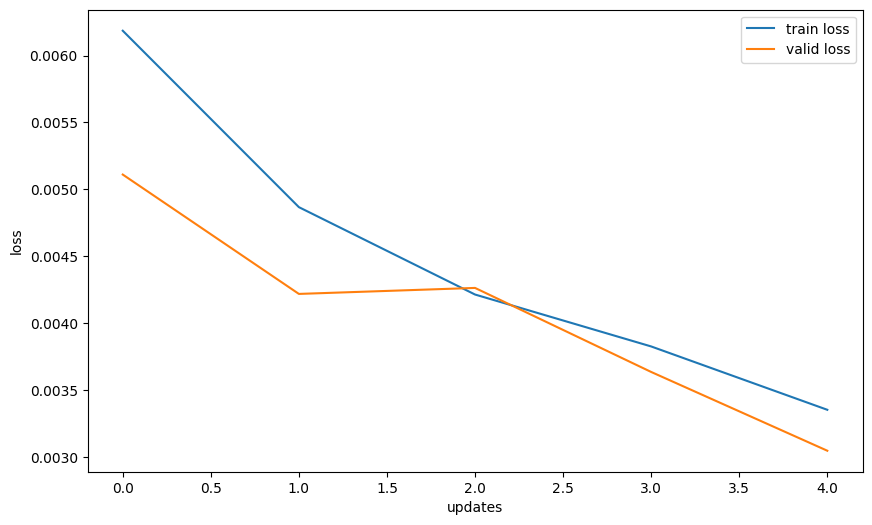

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

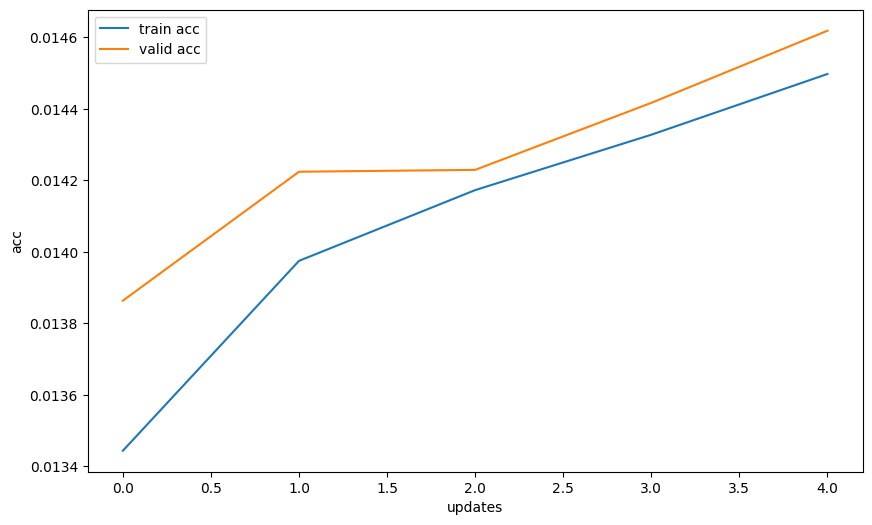

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [49]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_size)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.005 | Test Acc: 1.42%


## 8. Test on some random news

In [50]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  199,    27,   239,  1965, 48161,     6,    14,    21,   396,    27,
         2121,  1378,   239,     6], device='cuda:0')

In [51]:
text_list = [x.item() for x in text]
text_list

[199, 27, 239, 1965, 48161, 6, 14, 21, 396, 27, 2121, 1378, 239, 6]

In [52]:
[id2word[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [53]:
text = text.reshape(1, -1)  #because batch_size is 1

In [54]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [55]:
text.shape

torch.Size([1, 14])

In [56]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [57]:
predict(text, text_length)

tensor([3], device='cuda:0')